In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from ml_lib.controllers.Controller import Controller as Control
from ml_lib.clusters.DataCluster import DataCluster as Data
from ml_lib.clusters.LearnCluster import LearnCluster as Learn
from ml_lib.clusters.MergeCluster import MergeCluster as Merge

In [3]:
from ml_lib.utils.learn_modules.learners.GradientLearner import GradientLearner
from ml_lib.utils.learn_modules.learners.NewtonLearner import NewtonLearner
from ml_lib.utils.learn_modules.learners.MomentumLearner import MomentumLearner
from ml_lib.utils.learn_modules.learners.SmoothLearner import SmoothLearner

from ml_lib.utils.learn_modules.activators.LinearActivate import LinearActivate
from ml_lib.utils.learn_modules.activators.SigmoidActivate import SigmoidActivate
from ml_lib.utils.learn_modules.activators.TanhActivator import TanhActivator
from ml_lib.utils.learn_modules.activators.ReluActivator import ReluActivator

In [4]:
dataset = pd.read_csv(
    'data_files/kc_house_data.csv',
    index_col = 'id', parse_dates = ['date'], date_parser = lambda x: pd.datetime.strptime(x, '%Y%m%dT%H%M%S')
)
dataset = dataset[[col for col in dataset.columns if not col.endswith('15')]]
feature_cols = ['sqft_living', 'bedrooms', 'bathrooms']
target_cols = ['price']
dataset[target_cols] = np.log(dataset[target_cols])

In [5]:
verbose = False

learner = SmoothLearner
learner_kwargs = {
    'learn_rate': 1e-1
}

loss_kwargs = {}

nesterov = True

activator = ReluActivator
activator_kwargs = {
    'leak': 0.1
}

batcher_kwargs = {
    'proportion': 1.0
}

control = Control(
    'regression_controller',
    loss_smooth_coefs = [0.9, 100]
)

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module_kwargs = {
            'nodes': 128,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose, 'nesterov': nesterov,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator_kwargs': {'verbose': verbose},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [6]:
control.train_model(1000)

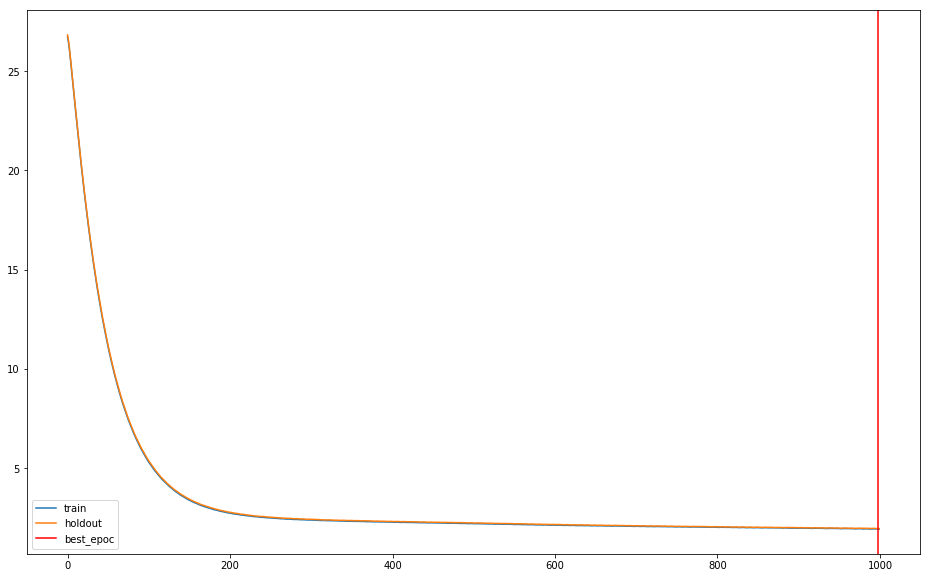

In [7]:
control.plot_losses()

In [8]:
control.predict({'data_cluster': dataset[feature_cols + target_cols]})

{'outputs': {'learn_cluster_1': array([[ 0.75743645,  2.8894954 , -0.10337601, ..., -0.15764149,
          -0.3132232 ,  0.54501903],
         [-0.07903371, -0.03585723,  0.44816133, ...,  0.83899045,
           1.4409597 ,  0.4707098 ],
         [-0.0227714 ,  4.146715  , -0.06512069, ..., -0.1116174 ,
          -0.21071382,  2.749917  ],
         ...,
         [-0.00439827,  4.2377815 , -0.07228157, ..., -0.10078613,
          -0.23816924,  2.5559356 ],
         [-0.0802491 ,  0.31201676,  0.21325818, ..., -0.00757687,
           0.842672  ,  0.9494775 ],
         [-0.00439827,  4.2377815 , -0.07228157, ..., -0.10078613,
          -0.23816924,  2.5559356 ]], dtype=float32),
  'learn_cluster_2': array([[ 0.82434213, -0.71798486, 13.857697  , ..., -0.6665395 ,
           3.2799563 , -0.6874368 ],
         [-0.06953632,  4.911432  , -0.17439303, ...,  3.7117941 ,
           4.6624365 , -1.0604767 ],
         [ 1.2927545 , -0.67238706, 12.620867  , ...,  5.291447  ,
          14.03426   

In [9]:
control.network_coefs()

{'learn_cluster_1': tensor([[-0.1404,  0.0468, -0.0634, -0.1591, -0.0641, -0.0726,  0.0067, -0.0231,
          -0.1503, -0.0456,  0.7433,  0.1635, -0.2840, -0.0976,  0.3889, -0.1339,
          -0.0199,  0.2452,  0.1888, -0.2093, -0.1024, -0.2032,  0.2574, -0.2347,
          -0.5238, -0.0290, -0.3455,  0.1862,  0.0189, -0.4685, -0.2966,  0.0437,
           0.0911,  0.0318, -0.0210,  0.0280,  0.0110, -0.0985, -0.3133, -0.1550,
          -0.5867, -0.0154, -0.0344, -0.2393, -0.2138, -0.4452, -0.2417, -0.4683,
           0.1323,  0.1169, -0.3330, -0.0352, -0.3500,  0.0823,  0.3185,  0.0538,
          -0.0886,  0.1902, -0.1553, -0.4722, -0.0616,  0.0030, -0.0730,  0.0466,
          -0.7997, -0.3658, -0.1965, -0.2413, -0.0012, -0.2140, -0.3392, -0.4412,
           0.0490,  0.0702, -0.4824, -0.3214, -0.2404,  0.3539,  0.0610, -0.4732,
           0.0949, -0.4333, -0.0002,  0.0908, -0.0555,  0.3238,  0.0195, -0.0451,
          -0.2771, -0.5286,  0.1050,  0.0071, -0.4730, -0.3661,  0.0191, -0.474